In [1]:
import sys
import numpy as np
import pandas as pd
import matplotlib
import loompy
import matplotlib.pyplot as plt
import scipy.optimize
import velocyto as vcy
import glob
from sklearn.decomposition import PCA
from scipy.spatial.distance import pdist, squareform
import pickle
import pixiedust
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
%matplotlib inline

Pixiedust database opened successfully


In [2]:
!mkdir data

mkdir: cannot create directory ‘data’: File exists


In [3]:
from urllib.request import urlretrieve
urlretrieve("http://pklab.med.harvard.edu/velocyto/hgForebrainGlut/hgForebrainGlut.loom", "data/hgForebrainGlut.loom")

('data/hgForebrainGlut.loom', <http.client.HTTPMessage at 0x7f994538ce50>)

In [4]:
import logging
logging.basicConfig(stream=sys.stdout, format='%(asctime)s - %(levelname)s - %(message)s', level=logging.DEBUG)

In [5]:
# Wrap implementation
import rpy2.robjects as robj
from rpy2.robjects.packages import importr

def array_to_rmatrix(X):
    nr, nc = X.shape
    xvec = robj.FloatVector(X.transpose().reshape((X.size)))
    xr = robj.r.matrix(xvec, nrow=nr, ncol=nc)
    return xr

def principal_curve(X, pca=True):
    """
    input : numpy.array
    returns:
    Result::Object
        Methods:
        projections - the matrix of the projectiond
        ixsort - the order ot the points (as in argsort)
        arclength - the lenght of the arc from the beginning to the point
    """
    # convert array to R matrix
    xr = array_to_rmatrix(X)
    
    if pca:
        #perform pca
        t = robj.r.prcomp(xr)
        #determine dimensionality reduction
        usedcomp = max( sum( np.array(t[t.names.index('sdev')]) > 1.1) , 4)
        usedcomp = min([usedcomp, sum( np.array(t[t.names.index('sdev')]) > 0.25), X.shape[0]])
        Xpc = np.array(t[t.names.index('x')])[:,:usedcomp]
        # convert array to R matrix
        xr = array_to_rmatrix(Xpc)

    #import the correct namespace
    princurve = importr("princurve", on_conflict='warn')
    
    #call the function
    fit1 = princurve.principal_curve(xr)
    
    #extract the outputs
    class Results:
        pass
    results = Results()
    results.projections = np.array( fit1[0] )
    results.ixsort = np.array( fit1[1] ) - 1 # R is 1 indexed
    results.arclength = np.array( fit1[2] )
    results.dist = np.array( fit1[3] )
    
    if pca:
        results.PCs = np.array(xr) #only the used components
        
    return results

# Load raw data

In [6]:
vlm = vcy.VelocytoLoom("data/hgForebrainGlut.loom")

In [7]:
vlm.ca  # you can see the barcodes in the CellID directly

{'CellID': array(['10X_17_028:AACCATGGTAATCACCx', '10X_17_028:AACCATGCATACTACGx',
        '10X_17_028:AAACCTGGTAAAGGAGx', ...,
        '10X_17_029:TTTGGTTGTACCCAATx', '10X_17_029:TTTCCTCCAGTCCTTCx',
        '10X_17_029:TTTGCGCCACAGATTCx'], dtype=object),
 'Clusters': array([3, 3, 1, ..., 6, 0, 1])}

In [8]:
vlm.ca['CellID']

array(['10X_17_028:AACCATGGTAATCACCx', '10X_17_028:AACCATGCATACTACGx',
       '10X_17_028:AAACCTGGTAAAGGAGx', ...,
       '10X_17_029:TTTGGTTGTACCCAATx', '10X_17_029:TTTCCTCCAGTCCTTCx',
       '10X_17_029:TTTGCGCCACAGATTCx'], dtype=object)

In [9]:
labels = vlm.ca["Clusters"]
manual_annotation = {str(i):[i] for i in labels}
manual_annotation

{'3': [3], '1': [1], '0': [0], '6': [6], '5': [5], '4': [4], '2': [2]}

In [10]:
# Load an initial clustering (Louvein)
labels = vlm.ca["Clusters"]
manual_annotation = {str(i):[i] for i in labels}
annotation_dict = {v:k for k, values in manual_annotation.items() for v in values }
clusters = np.array([annotation_dict[i] for i in labels])
colors20 = np.vstack((plt.cm.tab20b(np.linspace(0., 1, 20))[::2], plt.cm.tab20c(np.linspace(0, 1, 20))[1::2]))  # (20, 4) colors
vlm.set_clusters(clusters, cluster_colors_dict={k:colors20[v[0] % 20,:] for k,v in manual_annotation.items()})

In [11]:
np.arange(6)[1::2]

array([1, 3, 5])

# Load tsne and clusters from pagoda

2019-11-19 22:23:20,950 - DEBUG - findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
2019-11-19 22:23:20,951 - DEBUG - findfont: score(<Font 'STIXSizeOneSym' (STIXSizOneSymBol.ttf) normal normal bold normal>) = 10.335
2019-11-19 22:23:20,951 - DEBUG - findfont: score(<Font 'cmmi10' (cmmi10.ttf) normal normal 400 normal>) = 10.05
2019-11-19 22:23:20,952 - DEBUG - findfont: score(<Font 'STIXSizeThreeSym' (STIXSizThreeSymReg.ttf) normal normal regular normal>) = 10.05
2019-11-19 22:23:20,952 - DEBUG - findfont: score(<Font 'STIXSizeFourSym' (STIXSizFourSymReg.ttf) normal normal regular normal>) = 10.05
2019-11-19 22:23:20,953 - DEBUG - findfont: score(<Font 'STIXSizeFourSym' (STIXSizFourSymBol.ttf) normal normal bold normal>) = 10.335
2019-11-19 22:23:20,954 - DEBUG - findfont: score(<Font 'DejaVu Sans' (DejaVuSans.ttf) normal normal 400 normal>) = 0.05
2019-11-19 22:23:20,957 - DEBUG - findfont: score(<Font 'DejaVu Serif' (DejaVuSeri

2019-11-19 22:23:21,003 - DEBUG - findfont: score(<Font 'padmaa' (padmaa.ttf) normal normal 400 normal>) = 10.05
2019-11-19 22:23:21,004 - DEBUG - findfont: score(<Font 'KacstPen' (KacstPen.ttf) normal normal 400 normal>) = 10.05
2019-11-19 22:23:21,004 - DEBUG - findfont: score(<Font 'Liberation Serif' (LiberationSerif-BoldItalic.ttf) italic normal bold normal>) = 11.335
2019-11-19 22:23:21,005 - DEBUG - findfont: score(<Font 'Gubbi' (Gubbi.ttf) normal normal 400 normal>) = 10.05
2019-11-19 22:23:21,006 - DEBUG - findfont: score(<Font 'Likhan' (LikhanNormal.ttf) normal normal 400 normal>) = 10.05
2019-11-19 22:23:21,006 - DEBUG - findfont: score(<Font 'KacstTitleL' (KacstTitleL.ttf) normal normal 400 normal>) = 10.05
2019-11-19 22:23:21,007 - DEBUG - findfont: score(<Font 'Norasi' (Norasi-Italic.ttf) italic normal 400 normal>) = 11.05
2019-11-19 22:23:21,007 - DEBUG - findfont: score(<Font 'KacstBook' (KacstBook.ttf) normal normal book normal>) = 10.05
2019-11-19 22:23:21,008 - DEBUG 

2019-11-19 22:23:21,054 - DEBUG - findfont: score(<Font 'Noto Serif CJK JP' (NotoSerifCJK-ExtraLight.ttc) normal normal light normal>) = 10.24
2019-11-19 22:23:21,055 - DEBUG - findfont: score(<Font 'KacstNaskh' (KacstNaskh.ttf) normal normal 400 normal>) = 10.05
2019-11-19 22:23:21,056 - DEBUG - findfont: score(<Font 'FreeMono' (FreeMonoBoldOblique.ttf) oblique normal bold normal>) = 11.335
2019-11-19 22:23:21,057 - DEBUG - findfont: score(<Font 'Samyak Devanagari' (Samyak-Devanagari.ttf) normal normal 400 normal>) = 10.05
2019-11-19 22:23:21,058 - DEBUG - findfont: score(<Font 'Kinnari' (Kinnari-Italic.ttf) italic normal 400 normal>) = 11.05
2019-11-19 22:23:21,058 - DEBUG - findfont: score(<Font 'Gargi' (Gargi.ttf) normal normal 400 normal>) = 10.05
2019-11-19 22:23:21,059 - DEBUG - findfont: score(<Font 'Norasi' (Norasi-Oblique.ttf) oblique normal 400 normal>) = 11.05
2019-11-19 22:23:21,060 - DEBUG - findfont: score(<Font 'KacstLetter' (KacstLetter.ttf) normal normal 400 normal>) 

2019-11-19 22:23:21,092 - DEBUG - findfont: score(<Font 'Rachana' (Rachana-Regular.ttf) normal normal regular normal>) = 10.05
2019-11-19 22:23:21,092 - DEBUG - findfont: score(<Font 'Liberation Sans Narrow' (LiberationSansNarrow-Regular.ttf) normal normal 400 condensed>) = 10.25
2019-11-19 22:23:21,093 - DEBUG - findfont: score(<Font 'Lohit Gurmukhi' (Lohit-Gurmukhi.ttf) normal normal 400 normal>) = 10.05
2019-11-19 22:23:21,093 - DEBUG - findfont: score(<Font 'Ubuntu' (Ubuntu-LI.ttf) italic normal light normal>) = 11.24
2019-11-19 22:23:21,094 - DEBUG - findfont: score(<Font 'Ubuntu Mono' (UbuntuMono-B.ttf) normal normal bold normal>) = 10.335
2019-11-19 22:23:21,095 - DEBUG - findfont: score(<Font 'Waree' (Waree-BoldOblique.ttf) oblique normal bold normal>) = 11.335
2019-11-19 22:23:21,095 - DEBUG - findfont: score(<Font 'KacstFarsi' (KacstFarsi.ttf) normal normal 400 normal>) = 10.05
2019-11-19 22:23:21,096 - DEBUG - findfont: score(<Font 'Purisa' (Purisa-Oblique.ttf) oblique norma

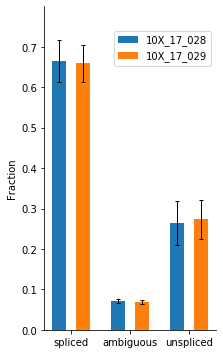

In [12]:
vlm.plot_fractions()

# Velocity Analysis

In [13]:
# %%pixie_debugger
# just to find the initial cell size
vlm.normalize("S", size=True, log=False)
vlm.normalize("U", size=True,  log=False)
# you are making the total sum of gene expressions equally among cells, which is impossible in real case! So what is here doing?! So weird

(array([ 94., 351., 645., 416., 147.,  38.,  11.,  13.,   3.,   2.]),
 array([ 2407.,  4755.,  7103.,  9451., 11799., 14147., 16495., 18843.,
        21191., 23539., 25887.]),
 <a list of 10 Patch objects>)

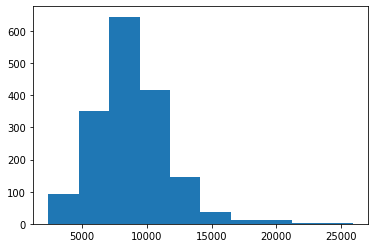

In [14]:
plt.hist(vlm.S.sum(0) + vlm.A.sum(0) + vlm.U.sum(0))

In [15]:
# these two lines delete the genes that do not express that much. So brute force; After this line U / S only has 10218 genes
vlm.score_detection_levels(min_expr_counts=30, min_cells_express=20,
                           min_expr_counts_U=0, min_cells_express_U=0)
vlm.filter_genes(by_detection_levels=True)  # they filter both on S, U with the same filter

2019-11-19 22:23:24,158 - DEBUG - Filtering by detection level


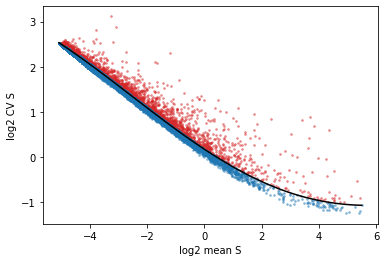

In [16]:
# %%pixie_debugger
# the first parameter controls the number of genes to select. So here they cut again to 2000 genes. 
# And seems they select the genes with higher sigma given some mean, I dont know why exactly they are soing this?
# Are you doing some dimension reduction? Reuce these with not enough variance?
# You have pca later, why are you doing this here
vlm.score_cv_vs_mean(2000, plot=True, max_expr_avg=50, winsorize=True, winsor_perc=(1,99.8), svr_gamma=0.01, min_expr_cells=50)

In [17]:
vlm.filter_genes(by_cv_vs_mean=True)  # filter here again

2019-11-19 22:23:26,083 - DEBUG - Filtering by cv vs mean


In [18]:
vlm.score_detection_levels(min_expr_counts=0, min_cells_express=0,
                           min_expr_counts_U=25, min_cells_express_U=20)
vlm.score_cluster_expression(min_avg_U=0.007, min_avg_S=0.06)
vlm.filter_genes(by_detection_levels=True, by_cluster_expression=True)
vlm.normalize_by_total(min_perc_U=0.5)
vlm.adjust_totS_totU(normalize_total=True, fit_with_low_U=False, svr_C=1, svr_gamma=1e-04) # denoise again, similar to filter the expression

2019-11-19 22:23:26,853 - INFO - Cluster: 0 (187 cells)
2019-11-19 22:23:26,859 - INFO - Cluster: 1 (332 cells)
2019-11-19 22:23:26,865 - INFO - Cluster: 2 (94 cells)
2019-11-19 22:23:26,869 - INFO - Cluster: 3 (249 cells)
2019-11-19 22:23:26,875 - INFO - Cluster: 4 (347 cells)
2019-11-19 22:23:26,882 - INFO - Cluster: 5 (243 cells)
2019-11-19 22:23:26,888 - INFO - Cluster: 6 (268 cells)
2019-11-19 22:23:26,898 - DEBUG - Filtering by cluster expression
2019-11-19 22:23:26,899 - DEBUG - Filtering by detection level


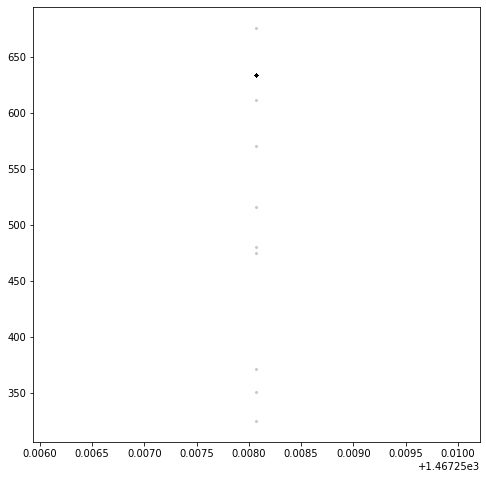

In [19]:
vlm.adjust_totS_totU(normalize_total=True, fit_with_low_U=False, svr_C=1, svr_gamma=1e-04, plot=True)

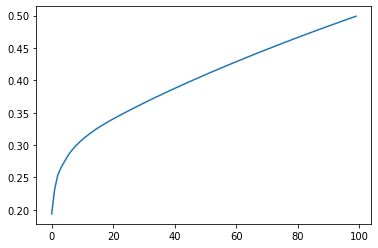

In [20]:
vlm.perform_PCA()
plt.plot(np.cumsum(vlm.pca.explained_variance_ratio_)[:100])
n_comps = np.where(np.diff(np.diff(np.cumsum(vlm.pca.explained_variance_ratio_))>0.0055))[0][0]
vlm.pcs[:,1] *= -1 # flip for consistency with previous version

In [21]:
n_comps

6

In [22]:
vlm.pcs # features in pca space

array([[-2.86591714e+00, -8.12284210e+00,  2.31015199e+00, ...,
        -4.33861125e-02,  1.53343509e-02, -1.27906495e-02],
       [-2.52068367e+00, -7.16748046e+00,  1.75801828e+00, ...,
         1.07448249e-02,  4.13847208e-03, -4.91214863e-02],
       [ 1.19024069e+01,  1.29010924e+00,  1.45353645e+00, ...,
         1.05578077e-03,  2.95129138e-02, -1.26625028e-02],
       ...,
       [-1.04833422e+01,  7.87185192e+00,  4.93499439e-01, ...,
        -4.66635740e-02, -2.30417667e-03, -3.31514715e-02],
       [ 1.54842203e+01,  3.36652759e+00, -3.23422443e+00, ...,
        -3.87384809e-02,  1.80262490e-02, -5.77961390e-03],
       [ 1.06854249e+01, -1.60613727e+00,  5.02657535e+00, ...,
         3.33963527e-02,  4.30179495e-02,  1.45818337e-02]])

In [23]:
vlm.pcs.shape

(1720, 1448)

In [24]:
from sklearn.neighbors import NearestNeighbors
import igraph

In [25]:
nn = NearestNeighbors(50)
nn.fit(vlm.pcs[:,:4])
knn_pca = nn.kneighbors_graph(mode='distance')
knn_pca = knn_pca.tocoo()
G = igraph.Graph(list(zip(knn_pca.row, knn_pca.col)), directed=False, edge_attrs={'weight': knn_pca.data})
VxCl = G.community_multilevel(return_levels=False, weights="weight")
labels = np.array(VxCl.membership)

In [26]:
from numpy_groupies import aggregate, aggregate_np

In [27]:
pc_obj = principal_curve(vlm.pcs[:,:4], False)
pc_obj.arclength = np.max(pc_obj.arclength) - pc_obj.arclength  # transfer from distance to similarity
labels = np.argsort(np.argsort(aggregate_np(labels, pc_obj.arclength, func=np.median)))[labels]  # what the ...?! seems like they are making nonsense with this line?

/home/haotian/anaconda3/envs/velocity/lib/python3.7/site-packages/rpy2/robjects/packages_utils.py:127: UserWarning: Conflict when converting R symbols in the package "princurve" to Python symbols: 
-lines_principal_curve -> lines.principal_curve, lines.principal.curve
- plot_principal_curve -> plot.principal_curve, plot.principal.curve
- points_principal_curve -> points.principal_curve, points.principal.curve
  warn(msg)


In [28]:
pc_obj.arclength

array([26.86036685, 26.6442549 ,  8.30931508, ..., 44.91626781,
        2.57607777, 12.65729232])

In [29]:
manual_annotation = {str(i):[i] for i in labels}
annotation_dict = {v:k for k, values in manual_annotation.items() for v in values }
clusters = np.array([annotation_dict[i] for i in labels])
colors20 = np.vstack((plt.cm.tab20b(np.linspace(0., 1, 20))[::2], plt.cm.tab20c(np.linspace(0, 1, 20))[1::2]))  # this is just setting colors
vlm.set_clusters(clusters, cluster_colors_dict={k:colors20[v[0] % 20,:] for k,v in manual_annotation.items()})

In [30]:
k = 550
# you have a knn computing from some pca
# and now you are applying some knn smoothing on the data matrix based on that.
vlm.knn_imputation(n_pca_dims=n_comps,k=k, balanced=True,
                   b_sight=np.minimum(k*8, vlm.S.shape[1]-1),
                   b_maxl=np.minimum(k*4, vlm.S.shape[1]-1))


2019-11-19 22:23:38,460 - DEBUG - First search the 1719 nearest neighbours for 1720
2019-11-19 22:23:38,895 - DEBUG - Using the initialization network to find a 550-NN graph with maximum connectivity of 1719
2019-11-19 22:23:38,916 - DEBUG - Returning sparse matrix


In [31]:
vlm.normalize_median()
vlm.fit_gammas(maxmin_perc=[2,95], limit_gamma=True)

In [32]:
vlm.normalize(which="imputed", size=False, log=True)
vlm.Pcs = np.array(vlm.pcs[:,:2], order="C")  # the first two axis of the pca

In [33]:
print(vlm.gammas.shape, vlm.S_sz.shape)

(1448,) (1448, 1720)


# <span style="color:red">Look into the steady_state, find all the cells are steady?!</span>
(vlm.steady_state == False).nonzero()

In [34]:
vlm.predict_U()  # basically gamma * S
vlm.calculate_velocity()  # velocity is Ux - Upred = Ux - gamma * S_x
vlm.calculate_shift()  # the numerical integration step, but basically the velocity
vlm.extrapolate_cell_at_t(delta_t=1)  # calculate this one and then just have a look which one it looks like

In [35]:
# %%pixie_debugger
vlm.estimate_transition_prob(hidim="Sx_sz", embed="Pcs", transform="log", psc=1,
                             n_neighbors=150, knn_random=True, sampled_fraction=1)  # what it is doing with this one?! - compute the correlation coefficient

2019-11-19 22:24:00,715 - DEBUG - Calculate KNN in the embedding space


/home/haotian/anaconda3/envs/velocity/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3326: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


2019-11-19 22:24:01,175 - DEBUG - Correlation Calculation 'knn_random'
2019-11-19 22:24:03,832 - DEBUG - Correlation Calculation for negative control
2019-11-19 22:24:06,454 - WARNING - Nans encountered in corrcoef and corrected to 1s. If not identical cells were present it is probably a small isolated cluster converging after imputation.
2019-11-19 22:24:06,459 - WARNING - Nans encountered in corrcoef_random and corrected to 1s. If not identical cells were present it is probably a small isolated cluster converging after imputation.
2019-11-19 22:24:06,460 - DEBUG - Done Correlation Calculation


In [48]:
vlm.corrcoef[3][vlm.corrcoef[3].nonzero()].shape  # the correlation coefficient to the 150 neighbors

(151,)

In [62]:
vlm.embedding.T[:,None,:] - vlm.embedding.T[:,None,:]

(2, 1, 1720)

In [49]:
vlm.calculate_embedding_shift(sigma_corr = 0.05, expression_scaling=False)

2019-11-20 09:41:10,550 - DEBUG - Calculate transition probability
2019-11-20 09:41:10,583 - DEBUG - Calculate transition probability for negative control


In [32]:
vlm.calculate_grid_arrows(smooth=0.9, steps=(25, 25), n_neighbors=200)

2019-11-07 19:49:24,233 - WARNING - The arrow scale was set to be 'absolute' make sure you know how to properly interpret the plots


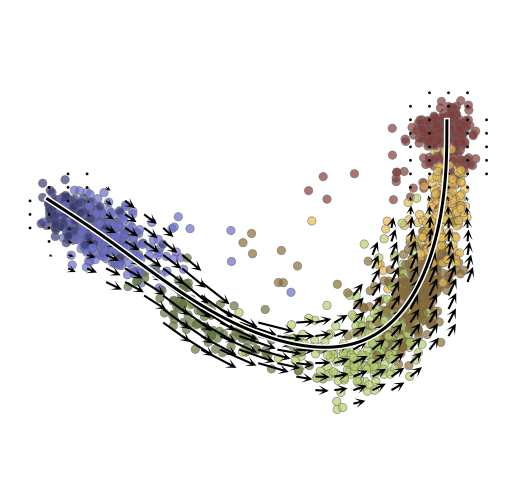

In [33]:
plt.figure(None,(9,9))
vlm.plot_grid_arrows(scatter_kwargs_dict={"alpha":0.7, "lw":0.7, "edgecolor":"0.4", "s":70, "rasterized":True},
                     min_mass=2.9, angles='xy', scale_units='xy',
                     headaxislength=2.75, headlength=5, headwidth=4.8, quiver_scale=0.35, scale_type="absolute")
plt.plot(pc_obj.projections[pc_obj.ixsort,0], pc_obj.projections[pc_obj.ixsort,1], c="w", lw=6, zorder=1000000)
plt.plot(pc_obj.projections[pc_obj.ixsort,0], pc_obj.projections[pc_obj.ixsort,1], c="k", lw=3, zorder=2000000)
plt.gca().invert_xaxis()
plt.axis("off")
plt.axis("equal");

## Plot level of expression by max proj

In [34]:
ds = loompy.connect("data/hgForebrainGlut.loom")

In [35]:
from matplotlib.colors import LinearSegmentedColormap
def scatter_lev(x, y, score, *args, **kwargs):
    ix_x_sort = np.argsort(score, kind="mergesort")
    ix_yx_sort = ix_x_sort
    args_new = []
    kwargs_new = {}
    for arg in args:
        if type(arg) is np.ndarray:
            args_new.append(arg[ix_x_sort][ix_yx_sort])
        else:
            args_new.append(arg)
    for karg, varg in kwargs.items():
        if type(varg) is np.ndarray:
            kwargs_new[karg] = varg[ix_x_sort][ix_yx_sort]
        else:
            kwargs_new[karg] = varg
    ax = plt.scatter(x[ix_x_sort][ix_yx_sort], y[ix_x_sort][ix_yx_sort], *args_new, **kwargs_new)
    return ax

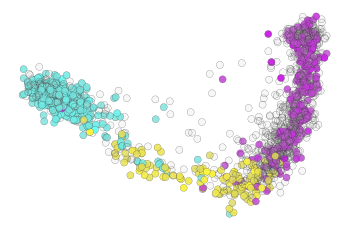

In [36]:
list_genes = np.array(["SOX2", "EOMES", "SLC17A7"])
list_colors = [[104,254,246,255], [251,243,66,255], [203,38,229,255]]
list_colors = np.array([np.array(i)/255 for i in list_colors])

# Extract level of expression
list_xs = []
list_s = []
for gene in list_genes:
    x = ds.layer["spliced"][np.where(ds.row_attrs["Gene"][:] == gene)[0][0], :]
    x = np.mean(vlm.initial_cell_size) * x / vlm.initial_cell_size
    list_s.append(x)
list_s = np.array(list_s)
scal_s = list_s / np.percentile(list_s, 98, 1)[:,None]
max_s = np.argmax(scal_s, 0)

# Make color Array
clarr = np.zeros((max_s.shape[0], 4))
clscore= np.zeros((max_s.shape[0]))
for i in range(len(list_genes)):
    base = (list_colors[i] + np.array([0.6,0.6,0.6, 0.3])) / 2.
    color_gene = LinearSegmentedColormap.from_list(f"color_{list_genes[i]}" , [base, list_colors[i]], )
    sel = (max_s==i) & (scal_s[i] > 0.45)
    clarr[(max_s==i), :] = np.array([0.7,0.7,0.7, 0.1])
    clarr[sel, :] = color_gene(np.log(scal_s[i]+1))[sel]
    clscore[sel] = np.log(scal_s[i]+1)[sel]
    
scatter_lev(-vlm.pcs[:,0], vlm.pcs[:,1], score=clarr[:,-1], c=clarr, s=50, lw=0.2, edgecolor="0.2", rasterized=True)

plt.axis("off");

# Plot different dynamics

Filter genes that peak at the different timepoints removing the ones that show low correlation between velocity and expression

In [37]:
segments = np.linspace(0, np.max(pc_obj.arclength),10)
fragments = -np.ones(pc_obj.arclength.shape, dtype=int)
for i in range(len(segments)-1):
    fragments[(pc_obj.arclength > segments[i]) & (pc_obj.arclength <= segments[i+1])] = i
    
medial_fragments = -np.ones(pc_obj.arclength.shape, dtype=int)
for i in range(len(segments)-2):
    medial_fragments[(pc_obj.arclength > segments[i:i+2].mean()) & (pc_obj.arclength < segments[i+1:i+3].mean())] = i
    
s = aggregate(fragments[fragments>=0], vlm.Sx_sz[:, fragments>=0], func="mean", axis=1)
u = aggregate(fragments[fragments>=0], vlm.Ux_sz[:, fragments>=0], func="mean", axis=1)
v = aggregate(medial_fragments[medial_fragments>=0], vlm.Sx_sz_t[:, medial_fragments>=0] - vlm.Sx_sz[:, medial_fragments>=0], func="mean", axis=1)

In [38]:
# Enrichment score by pseutotime
n_cells = vlm.cluster_ix.shape[0]

# Number of cells per cluster
sizes = np.bincount(vlm.cluster_ix)
# Number of nonzero values per cluster
nnz = aggregate(vlm.cluster_ix, (vlm.Sx_sz>0).astype(float), func="sum", axis=1)
# Mean value per cluster
means = aggregate(vlm.cluster_ix, vlm.Sx_sz, func="mean", axis=1)
# Non-zeros and means over all cells
nnz_overall, means_overall = (vlm.Sx_sz>0).sum(1), vlm.Sx_sz.mean(1)
# Scale by number of cells
f_nnz = nnz / sizes
f_nnz_overall = nnz_overall / n_cells

# Means and fraction non-zero values in other clusters (per cluster)
means_other = ((means_overall * n_cells)[None].T - (means * sizes)) / (n_cells - sizes)
f_nnz_other = ((f_nnz_overall * n_cells)[None].T - (f_nnz * sizes)) / (n_cells - sizes)

enrichment = (f_nnz + 0.1) / (f_nnz_overall[None].T + 0.1) * (means + 0.01) / (means_overall[None].T + 0.01)

In [39]:
#List of top eneriched genes
list_enriched = []
score_enriched = []
for i in range(enrichment.shape[1]):
    score_enriched.append(enrichment[:,i][np.argsort(enrichment[:,i])[::-1]][:350])
    list_enriched.append(vlm.ra["Gene"][np.argsort(enrichment[:,i])[::-1]][:350])

In [40]:
def clean_duplicates(list_enriched, score_enriched):
    for i in range(len(list_enriched)):
        current_ = list_enriched[i]
        for j in range(len(current_)):
            gj = current_[j]
            for n in range(len(list_enriched[i+1:])):
                if gj in list_enriched[n+i+1] and gj != "":
                    if score_enriched[n+i+1][np.where(list_enriched[n+i+1]==gj)[0][0]] > score_enriched[i][j]:
                        list_enriched[i][j] = ""
                    else:
                        list_enriched[n+i+1][np.where(list_enriched[n+i+1]==gj)[0][0]] = ""
    for i in range(enrichment.shape[1]):
        list_enriched[i] = list_enriched[i][list_enriched[i] != ""]
    return list_enriched

def paired_correlations(X, Y):
    Xm = X - X.mean(0)
    Ym = Y - Y.mean(0)
    return (Xm * Ym).sum(0) / (np.linalg.norm(Xm,2,0) * np.linalg.norm(Ym,2,0))

In [41]:
Cc = paired_correlations((s[:,1:] - s[:,:-1]).T, v.T)

In [42]:
for i in range(enrichment.shape[1]):
    selection_bool = np.in1d(list_enriched[i], vlm.ra["Gene"][Cc>0.55])
    score_enriched[i] = score_enriched[i][selection_bool][:120]
    list_enriched[i] = list_enriched[i][selection_bool][:120]

In [43]:
list_enriched = clean_duplicates(list_enriched, score_enriched)

selected_genes_n = int(np.mean([len(list_enriched[i]) for i in range(len(list_enriched))]))
for i in range(enrichment.shape[1]):
    list_enriched[i] = list_enriched[i][:selected_genes_n]
list_enriched_flat = np.hstack(list_enriched)

list_enriched_flat_new = []
for i in list_enriched_flat:
    if i not in list_enriched_flat_new:
        list_enriched_flat_new.append(i)
list_enriched_flat= np.array(list_enriched_flat_new)

In [44]:
s = aggregate(vlm.cluster_ix, vlm.Sx_sz, func="mean", axis=1)
u = aggregate(vlm.cluster_ix, vlm.Ux_sz, func="mean", axis=1)

ix_filter = np.where(np.in1d(vlm.ra["Gene"], list_enriched_flat))[0]
gene_filtered = vlm.ra["Gene"][ix_filter]

Ssort = s[ix_filter,:] / s[ix_filter,:].sum(1)[:,None]
Usort = u[ix_filter,:] / u[ix_filter,:].sum(1)[:,None]
ix1 = np.argsort(Usort.argmax(1), kind='mergesort')
ix2 = np.argsort(Ssort[ix1, :].argmax(1), kind='mergesort')
ixa2b = ix1[ix2]

In [45]:
ra_gene = np.array(vlm.ra["Gene"])[ix_filter][ixa2b]
gammas = np.array(vlm.gammas)[ix_filter][ixa2b]

S = s[ix_filter,:][ixa2b,:]
S_norm = np.array(S) - np.percentile(S, 1,1)[:,None]
S_norm = S_norm / np.percentile(S_norm, 99,1)[:,None]
S_norm = np.clip(S_norm, 0,1)

U = u[ix_filter,:][ixa2b,:]
U_norm = np.array(U) - np.percentile(U, 1,1)[:,None]
U_norm = U_norm / np.percentile(U_norm, 99,1)[:,None]
U_norm = np.clip(U_norm, 0,1)

In [46]:
from matplotlib import colors

2019-11-07 19:49:53,095 - DEBUG - locator: <matplotlib.ticker.FixedLocator object at 0x7f6b920f5a10>
2019-11-07 19:49:53,096 - DEBUG - Using fixed locator on colorbar
2019-11-07 19:49:53,099 - DEBUG - Setting pcolormesh


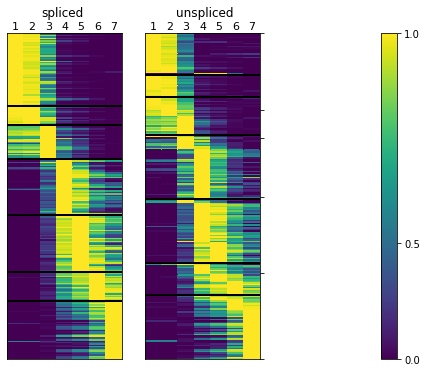

In [48]:
plt.figure(None, (7, 6))
plt.subplot(131)
plt.text(0.3,1.05,"spliced", fontdict={"size":12}, transform=plt.gca().transAxes )
plt.xticks(np.arange(s.shape[1])+0.5, np.arange(s.shape[1])+1, fontsize=11, ha="center", va="center");
plt.gca().tick_params(axis='x', labeltop=True, labelbottom=False, bottom=False )
plt.gca().tick_params(axis='y', labelleft=False, left=False )


plt.pcolormesh(S_norm, cmap=plt.cm.viridis, norm=colors.PowerNorm(gamma=1.5)) # aspect=0.1, interpolation="none"
plt.gca().invert_yaxis()
for hl in np.where(np.diff(Ssort[ixa2b, :].argmax(1)))[0]:
    plt.axhline(hl, c="k", lw=2)
    
plt.subplot(132)
plt.text(0.27,1.05,"unspliced", fontdict={"size":12}, transform=plt.gca().transAxes )
plt.xticks(np.arange(s.shape[1])+0.5, np.arange(s.shape[1])+1, fontsize=11, ha="center", va="center");
plt.gca().tick_params(axis='x', labeltop=True, labelbottom=False, bottom=False )
plt.gca().tick_params(axis='y', labelleft=False, left=False )


cax = plt.pcolormesh(U_norm, cmap=plt.cm.viridis,norm=colors.PowerNorm(gamma=1.5),) #aspect=0.1, interpolation="none",   
plt.gca().invert_yaxis()

for hl in np.where(np.diff(Ssort[ixa2b, :].argmax(1)))[0]:
    plt.axhline(hl, c="k", lw=2)

plt.gca().tick_params(axis='y', labelleft=False, left=False, right=True)
plt.yticks(np.where(np.in1d(ra_gene,["FAM64A", "RNASEH2B", "ELAVL4", "DCX", "STMN2", "GRIA3"]))[0])

plt.subplot(133)
plt.axis("off")
plt.colorbar(cax, ax=plt.gca(),ticks=[0,0.5,1.], orientation='vertical')

2019-11-07 19:50:04,069 - WARNING - 'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
2019-11-07 19:50:04,076 - WARNING - 'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
2019-11-07 19:50:04,106 - WARNING - 'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
2019-11-07 19:50:04,112 - WARNING - 'c' arg

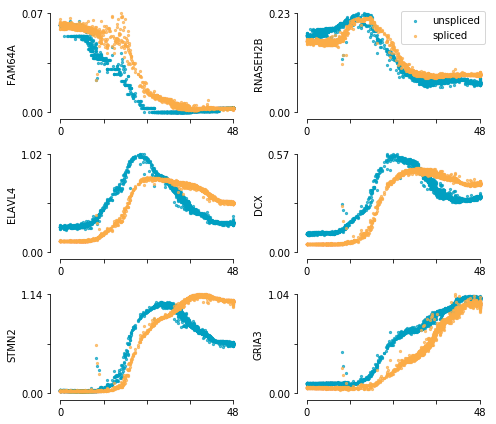

In [50]:
peek_shown = ["FAM64A", "RNASEH2B", "ELAVL4", "DCX", "STMN2", "GRIA3"]
plt.figure(None, (7,6.))
gs = plt.GridSpec(3,2)
for n, gene in enumerate(peek_shown):
    i = np.where(vlm.ra["Gene"] == gene)
    ax = plt.subplot(gs[n])
    plt.scatter(pc_obj.arclength[pc_obj.ixsort], vlm.Ux_sz[i, pc_obj.ixsort],
                alpha=0.7, c=np.array([0,159,193])/255, s=5, label="unspliced")
    plt.scatter(pc_obj.arclength[pc_obj.ixsort], vlm.Sx_sz[i, pc_obj.ixsort]*vlm.gammas[i],
                alpha=0.7, c=np.array([251, 172, 71])/255, s=5, label="spliced")
    m = 0 #np.minimum(np.min(vlm.Ux_sz[i,:]), np.min(vlm.Sx_sz[i,:]*vlm.gammas[i]))
    M = np.maximum(np.max(vlm.Ux_sz[i,:]), np.max(vlm.Sx_sz[i,:]*vlm.gammas[i]))
    plt.ylim(m - 0.07*(M-m), M + 0.07*(M-m))
    plt.ylabel(gene)
    plt.yticks([m,0.5*(m+M),M], [f"{m:.2f}", "", f"{M:.2f}"])
    p = np.min(pc_obj.arclength[pc_obj.ixsort])
    P = np.max(pc_obj.arclength[pc_obj.ixsort])
    plt.xticks(np.linspace(p,P,5), [f"{p:.0f}", "","","", f"{P:.0f}"])
    # Hide the right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    # Only show ticks on the left and bottom spines
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    ax.spines['left'].set_bounds(m, M)
    ax.spines['bottom'].set_bounds(p, P)
    if n == 1:
        plt.legend()
plt.tight_layout()